# 实验三：贝叶斯垃圾邮件识别
本次作业以垃圾邮件分类任务为基础，要求提取文本特征并使用朴素贝叶斯算法进行垃圾邮件识别（调用已有工具包或自行实现）。

## 1 任务介绍
电子邮件是互联网的一项重要服务，在大家的学习、工作和生活中会广泛使用。但是大家的邮箱常常被各种各样的垃圾邮件填充了。有统计显示，每天互联网上产生的垃圾邮件有几百亿近千亿的量级。因此，对电子邮件服务提供商来说，垃圾邮件过滤是一项重要功能。而朴素贝叶斯算法在垃圾邮件识别任务上一直表现非常好，至今仍然有很多系统在使用朴素贝叶斯算法作为基本的垃圾邮件识别算法。

本次实验数据集来自[Trec06](https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/foo06)的中文垃圾邮件数据集，目录解压后包含三个文件夹，其中data目录下是所有的邮件（未分词），已分词好的邮件在data_cut目录下。邮件分为邮件头部分和正文部分，两部分之间一般有空行隔开。标签数据在label文件夹下，文件中每行是标签和对应的邮件路径。‘spam’表示垃圾邮件，‘ham’表示正常邮件。

本次实验

基本要求：
1. 提取正文部分的文本特征；
2. 划分训练集和测试集（可以借助工具包。一般笔记本就足够运行所有数据，认为实现困难或算力不够的同学可以采样一部分数据进行实验。）；
3. 使用朴素贝叶斯算法完成垃圾邮件的分类与预测，要求测试集准确率Accuracy、精准率Precision、召回率Recall均高于0.9（本次实验可以使用已有的一些工具包完成如sklearn）；
4. 对比特征数目（词表大小）对模型效果的影响；
5. 提交代码和实验报告。

扩展要求：
1. 邮件头信息有时也可以协助判断垃圾邮件，欢迎学有余力的同学们尝试；
2. 尝试自行实现朴素贝叶斯算法细节；
3. 尝试对比不同的概率计算方法。

## 2 导入工具包

In [1]:
import random # 随机相关包
import numpy as np # 常用数学运算工具包
import pandas as pd # pandas数据分析库
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # 进度条工具包
from sklearn.model_selection import train_test_split # 数据集划分
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # 提取文本特征向量的类
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB # 三种朴素贝叶斯算法，差别在于估计p(x|y)的方式
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report # 评价指标

RANDOM_SEED = 2023

## 3 读取数据

In [2]:
data_path = './data/trec06c-utf8/data/' # 数据集目录
data_cut_path = './data/trec06c-utf8/data_cut/' # 切分数据集目录
index_path = './data/trec06c-utf8/label/index' # 标签文件路径

读取邮件，将其邮件头和正文根据空行分割开，读取成两个文件

In [3]:
def read_file(path): # 读取一个邮件文件，返回邮件头和正文信息
    with open(path, 'r', encoding='utf-8') as f: # 读入文件
        file = f.read()
        head = file.split('\n\n',maxsplit=1)[0]
        text = file.split('\n\n',maxsplit=1)[1]
    return head, text

test_head, test_text = read_file(data_path + '000/000')
print(f'HEAD:\n{test_head}')
print(f'\nTEXT:\n{test_text}')

HEAD:
Received: from hp-5e1fe6310264 ([218.79.188.136])
	by spam-gw.ccert.edu.cn (MIMEDefang) with ESMTP id j7CAoGvt023247
	for <lu@ccert.edu.cn>; Sun, 14 Aug 2005 09:59:04 +0800 (CST)
Message-ID: <200508121850.j7CAoGvt023247@spam-gw.ccert.edu.cn>
From: "yan"<(8月27-28,上海)培训课程>
Reply-To: yan@vip.163.com"<b4a7r0h0@vip.163.com>
To: lu@ccert.edu.cn
Subject: =?gb2312?B?t8eyxs7xvq3A7bXEssbO8bncwO0to6jJs8XMxKPE4qOp?=
Date: Tue, 30 Aug 2005 10:08:15 +0800
MIME-Version: 1.0
Content-type: multipart/related;
    type="multipart/alternative";
    boundary="----=_NextPart_000_004A_2531AAAC.6F950005"
X-Priority: 3
X-MSMail-Priority: Normal
X-Mailer: Microsoft Outlook Express 6.00.2800.1158
X-MimeOLE: Produced By Microsoft MimeOLE V6.00.2800.1441

TEXT:
                               [课 程 背 景]

   　
   每一位管理和技术人员都清楚地懂得，单纯从技术角度衡量为合算的方案，也许
   却是一个财务陷阱，表面赢利而暗地里亏损，使经
   营者无法接受。如何将技术手段与财务运作相结合，使每位管理和技术人员都从
   本课程通过沙盘模拟和案例分析，使企业各级管理和技术人员掌握财务管理知识
   ，利用财务信息改进管理决策，实现管理效益最大化。通过学习本课程，您将：
   ★ 对会计与财务管理有基本了解,提高日

根据index文件，对data文件进行读取
- 因为数据量较大，利用`tqdm`加入进度条显示读取进度

In [4]:
label_list, head_list, text_list = [], [], [] 
with open(index_path, 'r') as index_file: # 读入标签文件
    lines = [line.strip() for line in index_file if line.strip() != ''] # 读入所有非空行，并去掉换行符
    for line in tqdm(lines):
        label, path = line.split() # 分割为标签和文件路径
        label = 1 if label == 'spam' else 0 # 标签转化成0 1，垃圾邮件为1
        path = data_cut_path + path.replace('../data/','') #转换路径
        head, text = read_file(path) # 读入头信息和正文文本
        
        label_list.append(label)
        head_list.append(head)
        text_list.append(text)


  0%|                                                                                        | 0/64620 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████| 64620/64620 [00:20<00:00, 3108.41it/s]


将数据存储为`DataFrame`格式，并展示数据

In [5]:
df = pd.DataFrame({'labels': label_list, 'heads': head_list, 'texts': text_list})
df

,labels,heads,texts
0,1,Received: from hp-5e1fe6310264 ([218.79.188.13...,[ 课 程 背 景 ]\n\n \n每 一位 管理 和 技术人员 都 清楚 地 ...
1,0,Received: from jdl.ac.cn ([159.226.42.8])\n\tb...,讲 的 是 孔子 后人 的 故事 。 一个 老 领导 回到 家乡 ， 跟 儿子 感情 不 和...
2,1,Received: from 163.con ([61.141.165.252])\n\tb...,尊敬 的 贵 公司 ( 财务 / 经理 ) 负责人 您好 ！\n我 是 深圳 金海 实业 有...
3,1,Received: from 12.com ([222.50.6.150])\n\tby s...,贵 公司 负责人 ( 经理 / 财务 ） 您好 ：\n深圳市 华龙 公司 受 多家 公司 委...
4,1,Received: from dghhkjk.com ([59.36.183.208])\n...,这是 一封 HTML 格式 信件 ！\n\n- - - - - - - - - - - - ...
...,...,...,...
64615,1,Received: from 163.com ([218.18.139.38])\n\tby...,贵 公司 负责人 ( 经理 / 财务 ) 您好 ：\n我 公司 是 深圳市 华源 实业 有限...
64616,1,Received: from 12.com ([222.50.12.121])\n\tby ...,尊敬 的 商家 朋友 您好 ：\n我 是 深圳市 裕华 实业 有限公司 的 。 我司 实力雄...
64617,1,Received: from 163.com ([219.133.253.212])\n\t...,贵 公司 负责人 ( 经理 / 财务 ） 您好 !\n我 是 深圳市 康特 实业 有限公司 ...
64618,1,Received: from tencent-0ba99d8 ([210.22.28.223...,\n这是 一个 HTML 格式 的 邮件\nFRAME : easymain\n\n\n\n


## 4 划分数据集
经过老师讲解，了解应未在数据分析之前划分数据集

In [6]:
feature_cols = ['heads','texts']
X = df[feature_cols]
Y = df['labels']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)
print(X.shape, Y.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape) # 输出数据行列信息
# 将训练集进行二次划分，以便进行模型调优
xt_train, xt_test, yt_train, yt_test = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED)
print(xt_train.shape, xt_test.shape, yt_train.shape, yt_test.shape) # 输出数据行列信息

(64620, 2) (64620,) (51696, 2) (12924, 2) (51696,) (12924,)
(41356, 2) (10340, 2) (41356,) (10340,)


In [7]:
x_train.head(10)

,heads,texts
13202,Received: from mail.com ([222.175.114.131])\n\...,这里 所 凝聚 的 是 无数 网络 精英 的 心血 ， 在 往下读 之前 ， 请 先 让 自...
57760,Received: from 126.com ([219.133.129.188])\n\t...,\n贵 公司 负责人 :\n\n 你好 !\n\n 我 公司 为 深圳市 维拉\...
11829,Received: from mail.cernet.com (staff.cernet.c...,你 婆婆 的 表现 是 正常 的\n而 你 对 你 婆婆 有 这样 的 表现 没有 预计\n...
4439,Received: from 163.com ([219.148.61.13])\n\tby...,\n尊敬 的 阁下 :\n\n 我们 现在 正在 开展 一项 《 关于 青年 生活...
50671,Received: from lnfzb.com ([221.222.182.164])\n...,\n邮件 群发 - - - 最 直接 、 最 有效 的 广告 方式 !\n\n\n\n【 网...
12351,Received: from 163.com ([219.133.131.33])\n\tb...,贵 公司 负责人 ( 经理 / 财务 ) 您好 ：\n我 公司 是 深圳市 华源 实业 有限...
25373,Received: from 12565.com ([222.175.41.249])\n\...,红 十月 商务 王是 一款 自动 为 企业 发布 产品 信息 的 软件 （ 能够 在 十分钟...
51314,Received: from sea.net.edu.cn ([202.112.5.66])...,如 题 ， GG 会爱上 可 看透 你们 的 MM 吗 ？ 你们 会 不会 觉得 这样 的 ...
24542,Received: from 163.com ([219.134.22.61])\n\tby...,尊敬 的 公司 您好 ！ 打扰 之处 请 见谅 ！\n我 深圳 公司 愿 在 互惠互利 、 ...
15069,Received: from silversand.net ([219.136.103.68...,- - - - - - - 中国式 执行 与 海尔 兵法 大 / 型 / 公 / 开 / 课...


## 5 数据处理


通过Create_Vec创建文本向量化器（vectorizer）对象
- 通过选择不同参数来创建不同文vectorizer
- V_type：可选CV（CountVectorizer）和TV（TfidfVectorizer）
- max_df：用于指定词汇在文档中的最大出现频率。取值：0.0-1.0，例如0.8表示忽略在80%以上的文档中出现的词汇。
- min_df：用于指定词汇在文档中的最小出现数目。取值：整数，例如2表示忽略在不到2个文档中出现的词汇。

In [8]:
# 通过Create_Vec创建文本向量化器（vectorizer）对象
def Create_Vec(V_type,max_df,min_df):
    if (V_type == 'CV'):
        vectorizer = CountVectorizer(max_df = max_df, min_df = min_df)
    elif (V_type == 'TV'):
        vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    else:
        print('erro: vectorizer type wrong!')
        return 0
    return vectorizer
vectorizer = Create_Vec('TV',0.6,5)

根据创建的`vectorizer`来对数据集拟合转换
- 分别对`heads`与`tetxs`列进行转换，得到两类稀疏矩阵

将拟合转换后得到的稀疏矩阵图形化展示出来
- 利用`plt.spy`函数绘制稀疏矩阵非零元素分布
- 其横坐标表示矩阵的列索引，纵坐标表示矩阵的行索引。

(51696, 7802) (12924, 7802)


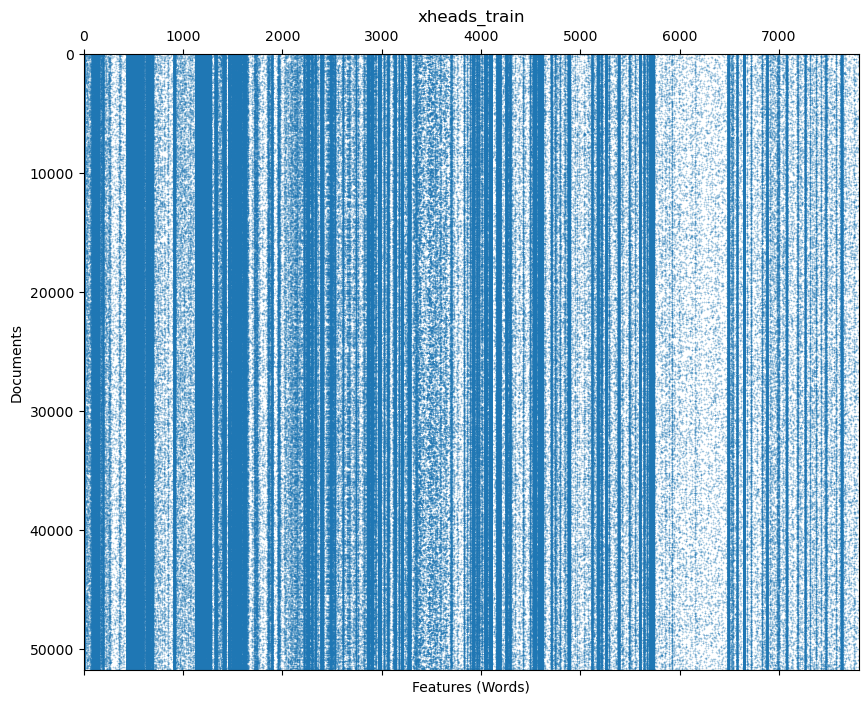

In [9]:
# 使用 fit_transform 进行拟合和转换
xheads_train = vectorizer.fit_transform(x_train['heads']) 
# 使用 transform 只进行数据的转换
xheads_test = vectorizer.transform(x_test['heads'])
print(xheads_train.shape, xheads_test.shape) # 输出矩阵大小

plt.figure(figsize=(10, 8))
# plt.spy 函数用于绘制稀疏矩阵的非零元素分布，其中横坐标表示矩阵的列索引，纵坐标表示矩阵的行索引。
plt.spy(xheads_train, markersize=0.1, aspect='auto')
plt.xlabel('Features (Words)')
plt.ylabel('Documents')
plt.title('xheads_train')
plt.show()

(51696, 66591) (12924, 66591)


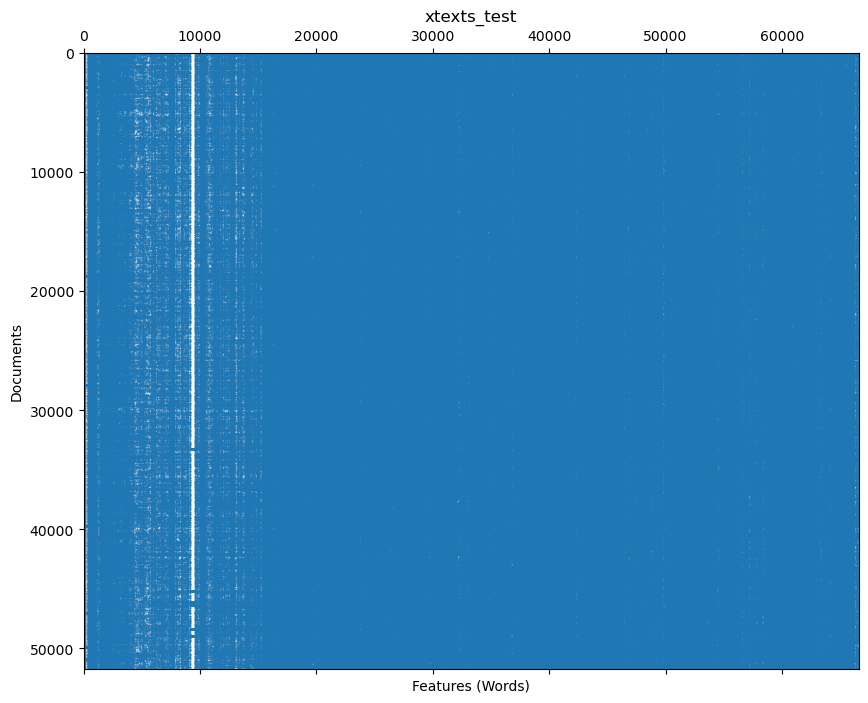

In [10]:
# 使用 fit_transform 进行拟合和转换
xtexts_train = vectorizer.fit_transform(x_train['texts']) 
# 使用 transform 只进行数据的转换
xtexts_test = vectorizer.transform(x_test['texts'])
print(xtexts_train.shape, xtexts_test.shape) # 输出矩阵大小

plt.figure(figsize=(10, 8))
# plt.spy 函数用于绘制稀疏矩阵的非零元素分布，其中横坐标表示矩阵的列索引，纵坐标表示矩阵的行索引。
plt.spy(xtexts_train, markersize=0.1, aspect='auto')
plt.xlabel('Features (Words)')
plt.ylabel('Documents')
plt.title('xtexts_test')
plt.show()

- 密集的区域通常表示在相应的列（特征）上有许多非零元素
- 稀疏的区域则表示在那些列上非零元素较少或没有
- 在文本数据的情境中，每一列对应于一个词汇或特征。因此，密集的竖线表示在这些词汇中有一些在文档中频繁出现，而稀疏的区域表示在这些词汇中有些在文档中很少或根本不出现。

## 6 模型训练
分别对邮件头和正文两部分进行训练，再最后根据一定权重合并两个模型

### 6.1 邮件头训练

In [11]:
# 使用Multinomial Naive Bayes对邮件头进行训练
model_heads = MultinomialNB()
model_heads.fit(xheads_train, y_train)

MultinomialNB()

获取 **邮件头** 中垃圾邮件与非垃圾邮件中权重最高的十个词汇，并利用柱状图显示

Top words for spam:
['0760' '21rgypq' '723' '86619861' '052' '00' '5628517' '64755262' '330'
 '3126050']
[0.01191201 0.01068648 0.00904696 0.00887319 0.00887307 0.00853443
 0.00790591 0.00784224 0.00745457 0.00742007]

Top words for non-spam:
['87583640' '5468' '5kg' '34006833' '86545574' '039' '050810' '21rgypq'
 '040969' '259']
[0.01826745 0.01589548 0.01152334 0.01011742 0.00788216 0.00783755
 0.00766951 0.00763002 0.00701033 0.00699732]


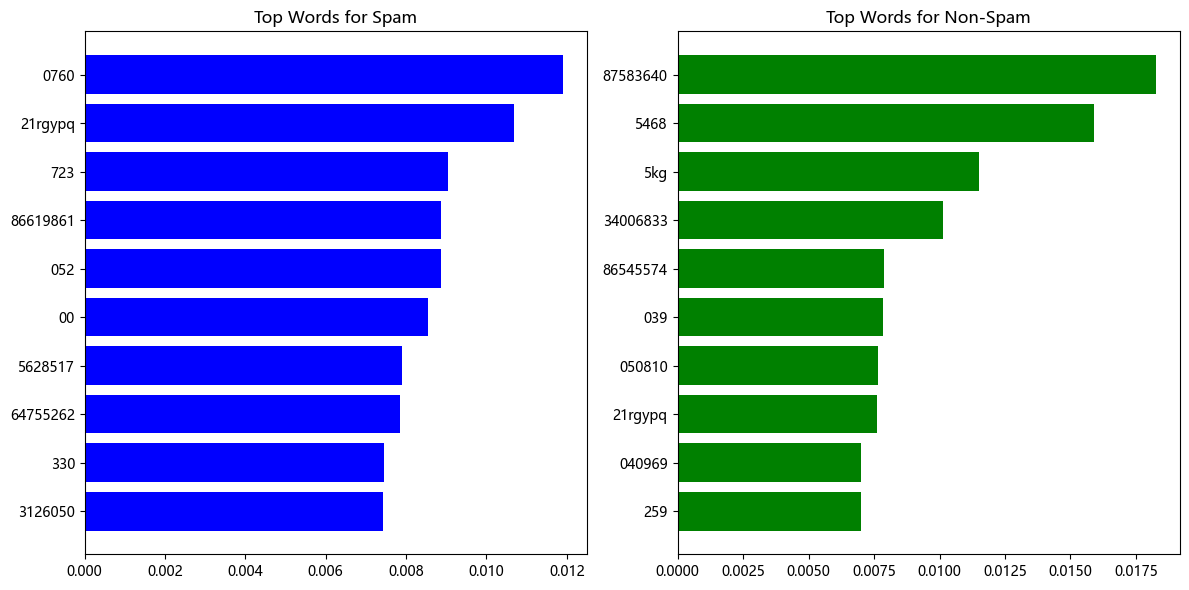

In [12]:
# 获取类别为垃圾邮件和非垃圾邮件的特征对数概率
spam_class_prob = model_heads.feature_log_prob_[1]
non_spam_class_prob = model_heads.feature_log_prob_[0]

# 将对数概率转换为概率
prob_spam = np.exp(spam_class_prob)
prob_non_spam = np.exp(non_spam_class_prob)

# 获取词汇表
vocab = np.array(vectorizer.get_feature_names_out())

# 获取最大权重的索引（即对数概率最大的特征）
top_spam_words = np.argsort(spam_class_prob)[::-1][:10]
top_non_spam_words = np.argsort(non_spam_class_prob)[::-1][:10]

# 输出垃圾邮件和非垃圾邮件的主要影响词汇
print("Top words for spam:")
print(vocab[top_spam_words])
print(prob_spam[top_spam_words])

print("\nTop words for non-spam:")
print(vocab[top_non_spam_words])
print(prob_non_spam[top_non_spam_words])


# 画图
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Microsoft YaHei'

plt.subplot(1, 2, 1)
plt.barh(range(10), prob_spam[top_spam_words], color='blue')
plt.yticks(range(10), vocab[top_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Spam')

plt.subplot(1, 2, 2)
plt.barh(range(10), prob_non_spam[top_non_spam_words], color='green')
plt.yticks(range(10), vocab[top_non_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Non-Spam')

plt.tight_layout()
plt.show()

### 6.2 邮件正文训练

In [13]:
# 使用Multinomial Naive Bayes对邮件正文进行训练
model_texts = MultinomialNB()
model_texts.fit(xtexts_train, y_train)

MultinomialNB()

获取 **邮件正文** 中垃圾邮件与非垃圾邮件中权重最高的十个词汇，并利用柱状图显示

Top words for spam:
['公司' '发票' 'com' '合作' '优惠' 'http' '有限公司' '我司' '代开' 'www']
[0.00820575 0.0065605  0.00384043 0.00351144 0.00315074 0.00289291
 0.00286094 0.0027401  0.00266387 0.00265106]

Top words for non-spam:
['一个' '自己' '没有' '我们' '觉得' '时候' 'mm' '什么' '知道' '这个']
[0.00305769 0.00296125 0.00271538 0.00211419 0.00210244 0.00206828
 0.00206705 0.00205005 0.00203816 0.00193213]


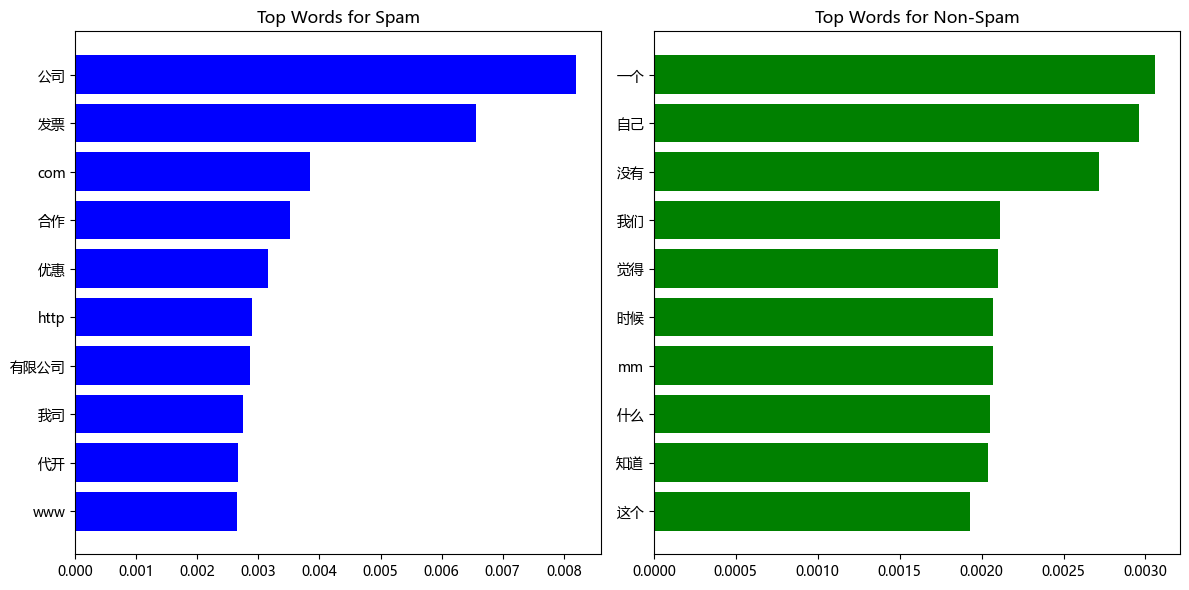

In [14]:
# 获取类别为垃圾邮件和非垃圾邮件的特征对数概率
spam_class_prob = model_texts.feature_log_prob_[1]
non_spam_class_prob = model_texts.feature_log_prob_[0]

# 将对数概率转换为概率
prob_spam = np.exp(spam_class_prob)
prob_non_spam = np.exp(non_spam_class_prob)

# 获取词汇表
vocab = np.array(vectorizer.get_feature_names_out())

# 获取最大权重的索引（即对数概率最大的特征）
top_spam_words = np.argsort(spam_class_prob)[::-1][:10]
top_non_spam_words = np.argsort(non_spam_class_prob)[::-1][:10]

# 输出垃圾邮件和非垃圾邮件的主要影响词汇
print("Top words for spam:")
print(vocab[top_spam_words])
print(prob_spam[top_spam_words])

print("\nTop words for non-spam:")
print(vocab[top_non_spam_words])
print(prob_non_spam[top_non_spam_words])


# 画图
plt.figure(figsize=(12, 6))
plt.rcParams['font.family'] = 'Microsoft YaHei'

plt.subplot(1, 2, 1)
plt.barh(range(10), prob_spam[top_spam_words], color='blue')
plt.yticks(range(10), vocab[top_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Spam')

plt.subplot(1, 2, 2)
plt.barh(range(10), prob_non_spam[top_non_spam_words], color='green')
plt.yticks(range(10), vocab[top_non_spam_words])
plt.gca().invert_yaxis()
plt.title('Top Words for Non-Spam')

plt.tight_layout()
plt.show()

### 6.3 模型预测
分别根据邮件头模型与邮件正文模型进行预测

In [15]:
# 根据邮件头预测测试集
yheads_pred = model_heads.predict(xheads_test)

# 根据邮件头训练模型评估模型性能
accuracy = accuracy_score(y_test, yheads_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, yheads_pred, zero_division=1))

Accuracy: 99.85%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4263
           1       1.00      1.00      1.00      8661

    accuracy                           1.00     12924
   macro avg       1.00      1.00      1.00     12924
weighted avg       1.00      1.00      1.00     12924



In [16]:
# 根据邮件正文预测测试集
ytexts_pred = model_texts.predict(xtexts_test)

# 根据邮件正文训练模型评估模型性能
accuracy = accuracy_score(y_test, ytexts_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, ytexts_pred, zero_division=1))

Accuracy: 97.76%
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4263
           1       0.98      0.98      0.98      8661

    accuracy                           0.98     12924
   macro avg       0.97      0.97      0.97     12924
weighted avg       0.98      0.98      0.98     12924



结果显示通过邮件头对垃圾邮件预测的准确率高于根据正文预测

### 6.4 根据不同权重融合两个模型
- 权重选择
    - 因为上述结果显示根据邮件头预测的准确率更高，选择了将邮件头权重给到0.6，邮件正文权重给到0.4
    - 将根据不同权重结合邮件头与正文的预测结果，得到一个新的预测值

- 阈值选择
    - 因为新的预测值由权重算来的，是一个0~1之间的浮点数，所以需要一个阈值来确定其是否判断为垃圾邮件
    - 通过绘制阈值与准确率的曲线找到最好的阈值与最高准确率

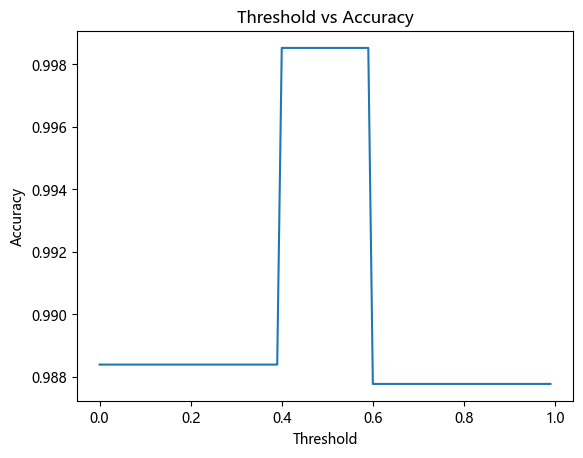

Best Threshold:  0.4
Best Accuracy:  0.998529866914268


In [17]:
# 定义权重weight，根据权重分配预测参数
weight = 0.6
y_pred_avr = weight * yheads_pred + (1 - weight) * ytexts_pred

# 定义阈值threshold ，根据阈值确定是否预测为
thresholds = np.arange(0, 1, 0.01)
accuracies = []

for t in thresholds:
    y_pred = (y_pred_avr > t).astype(int)
    
    # 计算accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 绘制阈值与accuracy关系曲线
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy') 
plt.title('Threshold vs Accuracy')
plt.show()

# 找到最高accuracy的阈值    
best_threshold = thresholds[np.argmax(accuracies)]   
print("Best Threshold: ", best_threshold) 
print("Best Accuracy: ", max(accuracies))

In [18]:
y_pred = (y_pred_avr > best_threshold).astype(int)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 99.85%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4263
           1       1.00      1.00      1.00      8661

    accuracy                           1.00     12924
   macro avg       1.00      1.00      1.00     12924
weighted avg       1.00      1.00      1.00     12924



## 7 模型调优
### 7.1 确定最好的权重与阈值
通过嵌套for循环，选择最好的权重与阈值

In [19]:
# 定义权重和阈值的范围
weights = np.arange(0, 1, 0.01)
thresholds = np.arange(0, 1, 0.01)

best_accuracy = 0
best_params = {'weight': None, 'threshold': None}

# 遍历权重和阈值
for weight in weights:
    for threshold in thresholds:
        # 计算加权平均预测值
        y_pred_avr = weight * yheads_pred + (1 - weight) * ytexts_pred
        
        # 根据阈值确定二分类预测
        y_pred = (y_pred_avr > threshold).astype(int)
        
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 更新最佳准确率和对应的参数
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['weight'] = weight
            best_params['threshold'] = threshold

# 输出最佳参数和准确率
print("Best Weight:", best_params['weight'])
print("Best Threshold:", best_params['threshold'])
print("Best Accuracy:", best_accuracy)


Best Weight: 0.51
Best Threshold: 0.49
Best Accuracy: 0.998529866914268


In [20]:
y_pred = (y_pred_avr > best_threshold).astype(int)

# 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 99.85%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4263
           1       1.00      1.00      1.00      8661

    accuracy                           1.00     12924
   macro avg       1.00      1.00      1.00     12924
weighted avg       1.00      1.00      1.00     12924



通过添加权重的方法合并两个训练的模型，并选取最优的权重与阈值，结果与只对邮件头训练得到的模型预测值相同

说明在该方法中，正文内容对提升准确率没有帮助

### 7.2 词表大小对准确率影响分析

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 23.80s/it]


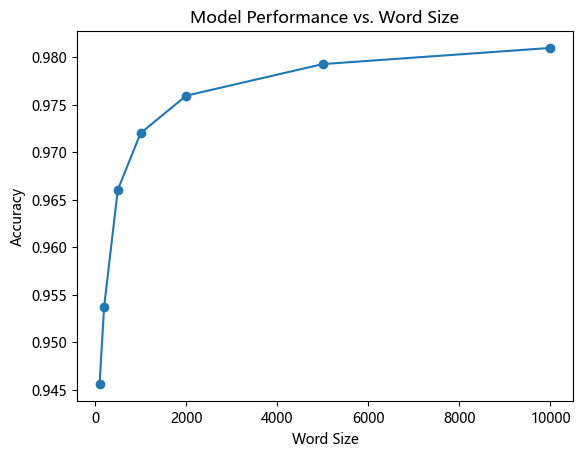

In [21]:
# 定义不同的词表大小
word_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]

# 存储结果的列表
accuracies = []

# 循环实验
for word_size in tqdm(word_sizes):
    # 配置文本向量化器
    vectorizer = CountVectorizer(max_features=word_size)
    
    # 数据处理
    xheads_train = vectorizer.fit_transform(x_train['heads']) 
    xheads_test = vectorizer.transform(x_test['heads'])
    xtexts_train = vectorizer.fit_transform(x_train['texts']) 
    xtexts_test = vectorizer.transform(x_test['texts'])

    # 模型训练
    model_heads = MultinomialNB()
    model_heads.fit(xheads_train, y_train)
    model_texts = MultinomialNB()
    model_texts.fit(xtexts_train, y_train)

    # 模型预测
    yheads_pred = model_heads.predict(xheads_test)
    ytexts_pred = model_texts.predict(xtexts_test)
    
    # 模型融合
    weights = 0.6
    thresholds = 0.4
    y_pred_avr = weight * yheads_pred + (1 - weight) * ytexts_pred
    y_pred = (y_pred_avr > threshold).astype(int)
    
    # 评估性能
    accuracy = accuracy_score(y_test, y_pred)
    
    # 存储结果
    accuracies.append(accuracy)

# 绘制折线图
plt.plot(word_sizes, accuracies, marker='o')
plt.title('Model Performance vs. Word Size')
plt.xlabel('Word Size')
plt.ylabel('Accuracy')
plt.show()

由图分析可见，词表越大，准确率越高，前期增长幅度较大，当词表大到一定程度增长减缓

### 7.3 通过遍历参数，选择最佳模型

通过遍历不同的vector类型、朴素贝叶斯算法、max_df范围、min_df范围等来确定最好的模型参数

In [22]:
# 设置参数范围
Vector_Types = ['CV','TV']          # vector类型
NBs = [BernoulliNB(), MultinomialNB(), ComplementNB()]  # 
max_dfs = np.arange(0.1, 1, 0.1)    # max_df范围
min_dfs = np.arange(1, 10, 1)     # min_df范围
weights = np.arange(0, 1, 0.1)     # 权重范围
thresholds = np.arange(0, 1, 0.1)  # 阈值范围

best_accuracy_head = 0
best_params_head = {'Vector_Type': None, 'NB_Type': None, 'max_df': None, 'min_df': None}

best_accuracy_text = 0
best_params_text = {'Vector_Type': None, 'NB_Type': None, 'max_df': None, 'min_df': None}

total = len(Vector_Types) * len(NBs) * len(max_dfs) * len(min_dfs)
pbar = tqdm(total=total) 

for Vtype in Vector_Types:
    for NB in NBs:
        for max_df in max_dfs:
            for min_df in min_dfs:
                # print(f'Vtype:{Vtype},NB:{NB},max_df:{max_df},min_df:{min_df}')
                vectorizer = Create_Vec(Vtype,max_df,min_df)
                # 邮件头格式转换
                xheads_train = vectorizer.fit_transform(xt_train['heads']) 
                xheads_test = vectorizer.transform(xt_test['heads'])
                NB.fit(xheads_train, yt_train) # 在训练集上训练
                yheads_pred = NB.predict(xheads_test) # 在测试集上预测，获得预测值
                accuracy_heads = accuracy_score(yt_test, yheads_pred) # 将测试预测值与测试集标签对比获得准确率
                # 迭代求最佳参数
                if accuracy_heads > best_accuracy_head:
                    best_accuracy_head = accuracy_heads
                    best_params_head['Vector_Type'] = Vtype
                    best_params_head['NB_Type'] = NB
                    best_params_head['max_df'] = max_df
                    best_params_head['min_df'] = min_df
                pbar.update(1)

pbar.close()

print("Best Vector Type :", best_params_head['Vector_Type'])
print("Best NB Type:", best_params_head['NB_Type'])
print("Best max_df:", best_params_head['max_df'])
print("Best min_df:", best_params_head['min_df'])
print("Best Accuracy:", best_accuracy_head)

  0%|                                                                                          | 0/486 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 486/486 [50:57<00:00,  6.29s/it]

Best Vector Type : TV
Best NB Type: MultinomialNB()
Best max_df: 0.1
Best min_df: 1
Best Accuracy: 0.9979690522243714


最终，确定了最佳参数为`TfidfVectorizer(max_df = 0.1,min_df = 1)`格式下训练出来的模型，用`MultinomialNB()`进行贝叶斯分析得到的准确率最高。

In [27]:
vectorizer = Create_Vec('TV',0.1,1)

# 数据处理
xheads_train = vectorizer.fit_transform(x_train['heads']) 
xheads_test = vectorizer.transform(x_test['heads'])
xtexts_train = vectorizer.fit_transform(x_train['texts']) 
xtexts_test = vectorizer.transform(x_test['texts'])

# 模型训练
model_heads = MultinomialNB()
model_heads.fit(xheads_train, y_train)
model_texts = MultinomialNB()
model_texts.fit(xtexts_train, y_train)

# 模型预测
yheads_pred = model_heads.predict(xheads_test)
ytexts_pred = model_texts.predict(xtexts_test)

# 模型调优
# 定义权重和阈值的范围
weights = np.arange(0, 1, 0.01)
thresholds = np.arange(0, 1, 0.01)

best_accuracy = 0
best_params = {'weight': None, 'threshold': None}

# 遍历权重和阈值
for weight in weights:
    for threshold in thresholds:
        # 计算加权平均预测值
        y_pred_avr = weight * yheads_pred + (1 - weight) * ytexts_pred
        
        # 根据阈值确定二分类预测
        y_pred = (y_pred_avr > threshold).astype(int)
        
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 更新最佳准确率和对应的参数
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['weight'] = weight
            best_params['threshold'] = threshold

# 输出最佳参数和准确率
print("Best Weight:", best_params['weight'])
print("Best Threshold:", best_params['threshold'])
print("Best Accuracy:", best_accuracy)

Best Weight: 0.51
Best Threshold: 0.49
Best Accuracy: 0.9986072423398329


最终选择了权重为0.6，阈值为0.4

In [28]:
best_weight = 0.6
best_threshold = 0.4

y_pred_avr = best_weight * yheads_pred + (1 - best_weight) * ytexts_pred
y_pred = (y_pred_avr > best_threshold).astype(int)

# 评估模型性能
best_acc = accuracy_score(y_test, y_pred) # 将测试预测值与测试集标签对比获得准确率
best_precision = precision_score(y_test, y_pred) # 精准率，判断为1的邮件中有多少真的为垃圾邮件，垃圾邮件分类任务中的重要指标，因为不希望将非垃圾邮件判为垃圾邮件
best_recall = recall_score(y_test, y_pred) # 召回率，真的垃圾邮件中有多少被识别出来
print(f'accuracy: {best_acc * 100:.4f}%, precision: {best_precision * 100:.4f}%, recall: {best_recall * 100:.4f}%') # 输出评价指标

accuracy: 99.8607%, precision: 100.0000%, recall: 99.7922%


## 8 总结
经过本次实验，我又学习到了更多的机器学习相关知识，也遇到了一些问题，收获丰富。
1. 这次数据集量比以往都大，所以读取数据、训练上花的时间更长，为了方便展示进展，我使用了`tqdm`来显示进度条。
2. 本次实验中含有许多的参数，为了找到最佳的参数，我进行了模型调优，要注意的是，调优时不能直接用测试集，不然会造成数据污染，应该在训练集上再进行划分进行数据调优。
3. 本次实验中我分别训练了根据邮件头和正文的模型，并将两种模型以不同的权重结合起来，以一定的阈值确定最后的预测结果。然而，我发现两个模型结合后的结果并不比单用邮件头更好。